In [1]:
# %reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skimage import measure
import numpy as np
import pandas as pd
import xlwings as xw
import os

class Capabilities:
    def __init__(self, material, gauge):
        self.material = material
        self.gauge = gauge
        self._extract_data()

    def _extract_data(self):
        self.cost_cells = {'Total Cost': 'U'}

        self.input_cols = {
            'length': 'L', 'width': 'M', 'quantity': 'C', 'process1': 'D', 'process2': 'E',
            'material_code': 'F', 'gauge': 'G', 'fastener_count': 'H', 
            'perimeter_plus_fastener': 'I', 'J': 'J', 'K': 'K', 'N': 'N'
        }

        self.gauge_material = f"{self.gauge}_{self.material}"

        self.thickness = {
            '16_GLV': 0.0635,
            '14_GLV': 0.0785,
            '12_GLV': 0.1084,
            '10_GLV': 0.1382,
            '8_GLV':  0.1624,
            '16_SST': 0.0625,
            '14_SST': 0.0781,
            '12_SST': 0.1094,
            '10_SST': 0.1406,
            '8_SST':  0.1644
        }

        self.max_flange_width = {
            '16_GLV': 149.6,
            '14_GLV': 149.6,
            '12_GLV': 149.6,
            '10_GLV': 118.11,
            '8_GLV':  0,
            '16_SST': 149.6,
            '14_SST': 118.11,
            '12_SST': 108.26,
            '10_SST': 82.67,
            '8_SST':  0
        }

        self.density = {
            '16_GLV': 0.018444444444444444,
            '14_GLV': 0.022784722222222224,
            '12_GLV': 0.03146527777777777,
            '10_GLV': 0.04014583333333333,
            '8_GLV':  0.048826389,
            '16_SST': 0.0175,
            '14_SST': 0.021875,
            '12_SST': 0.030625,
            '10_SST': 0.039375,
            '8_SST':  0.048125
        }

        self.region_colors = {
            'APB': '#66c2a5',
            'MPB': '#4f8cd6',
            'TL': '#e74c3c'
        }

        self.max_sheet_length = 180
        self.max_sheet_width = 60

        self.APB_max_flange_length = 8
        self.APB_min_flange_length = self.thickness[self.gauge_material] * 5
        self.APB_min_throat_length = 15.75
        self.APB_max_flat_diagonal = 157.48
        self.APB_max_mass = 286.6
        self.APB_min_width = self.APB_min_length = self.APB_min_throat_length + 2 * (self.APB_max_flange_length * 5/8)
        self.APB_max_width = self.APB_max_length = self.max_flange_width[self.gauge_material]

        self.MPB_max_dim = 168

        self.TL_max_length = 334.65
        self.TL_max_diagonal_width = 7.87
        self.TL_max_mass_per_length = 7.348
        self.TL_max_width = round(3*((self.TL_max_diagonal_width**2 / 2) ** 0.5), 2)

    def _get_constraints(self, min, max, n_points):
        # Create grid for all
        self.x = np.linspace(min, max, n_points)
        self.y = np.linspace(min, max, n_points)
        self.X, self.Y = np.meshgrid(self.x, self.y)

        # APB Constraints
        self.APB_feasible = np.zeros_like(self.X, dtype=bool)
        # MPB Constraints
        self.MPB_feasible = np.zeros_like(self.X, dtype=bool)
        # TL Constraints
        self.TL_feasible = np.zeros_like(self.X, dtype=bool)
        
        # For each point in the grid, check if it satisfies either orientation
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                x_val = self.X[i, j]
                y_val = self.Y[i, j]
                
                if self.gauge >= 10:
                    # Normal orientation check (x,y)
                    normal_valid_APB = (
                        (x_val >= self.APB_min_width) and (x_val <= self.APB_max_width) and
                        (y_val >= self.APB_min_length) and (y_val <= self.APB_max_length) and
                        (x_val**2 + y_val**2) <= self.APB_max_flat_diagonal**2 and
                        (x_val * y_val * self.density[self.gauge_material]) <= self.APB_max_mass and
                        (x_val <= self.max_sheet_width) and (y_val <= self.max_sheet_length)
                    )
                    
                    # Rotated orientation check (y,x)
                    rotated_valid_APB = (
                        (y_val >= self.APB_min_width) and (y_val <= self.APB_max_width) and
                        (x_val >= self.APB_min_length) and (x_val <= self.APB_max_length) and
                        (x_val**2 + y_val**2) <= self.APB_max_flat_diagonal**2 and
                        (x_val * y_val * self.density[self.gauge_material]) <= self.APB_max_mass and
                        (y_val <= self.max_sheet_width) and (x_val <= self.max_sheet_length)
                    )
                    
                    # If either orientation is valid, mark this point as valid
                    self.APB_feasible[i, j] = normal_valid_APB or rotated_valid_APB

                # Normal orientation check (x,y)
                normal_valid_MPB = (
                    (x_val < self.MPB_max_dim) and
                    (y_val < self.MPB_max_dim) and
                    (x_val <= self.max_sheet_width) and
                    (y_val <= self.max_sheet_length)
                )
            
                # Rotated orientation check (y,x)
                rotated_valid_MPB = (
                    (y_val < self.MPB_max_dim) and
                    (x_val < self.MPB_max_dim) and
                    (y_val <= self.max_sheet_width) and
                    (x_val <= self.max_sheet_length)
                )

                # If either orientation is valid, mark this point as valid
                self.MPB_feasible[i, j] = normal_valid_MPB or rotated_valid_MPB
                
                # Normal orientation check (x,y)
                normal_valid_TL = (
                    (y_val < self.TL_max_length) and
                    (x_val < self.TL_max_width) and
                    ((x_val * self.density[self.gauge_material]) <= self.TL_max_mass_per_length)
                )
            
                # Rotated orientation check (y,x)
                rotated_valid_TL = (
                    (x_val < self.TL_max_length) and
                    (y_val < self.TL_max_width) and
                    ((y_val * self.density[self.gauge_material]) <= self.TL_max_mass_per_length)
                )
            
                # If either orientation is valid, mark this point as valid
                self.TL_feasible[i, j] = normal_valid_TL or rotated_valid_TL
        
        self.region_masks = {
            'MPB': self.MPB_feasible,
            'APB': self.APB_feasible,
            'TL': self.TL_feasible
        }
    
    def _get_region_inputs(self, fastener_spacing=3):
        self.region_inputs = {
                'MPB': ('Manual Shear Laser', 'Manual Press Brake', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'APB': ('Auto Punch Shear', 'Auto Panel Bender', lambda l, w: round((2*l+2*w)/fastener_spacing, 0)),
                'TL':  ('Auto Tube Laser', 'Roll Form (outsourced)', lambda l, w: 2)
            }

    def _write_inputs_to_excel(self, excel_path, start_row, fastener_spacing, lengths, widths, quantities, process1s, process2s,
                                     material_codes, gauges, fastener_counts, perim_plus_fastener, Js, Ks, Ns):
        self._get_region_inputs(fastener_spacing)
        
        app = None
        wb = None
        try:
            print("Opening Excel workbook...")
            app = xw.App(visible=False)
            wb = app.books.open(excel_path)
            ws = wb.sheets['BAC Part List']
            print("Excel opened successfully")
            
            # Write all inputs in batch
            end_row = start_row + len(lengths) - 1
            
            print(f"Writing inputs to rows {start_row} to {end_row}...")
            ws.range(f"{self.input_cols['length']}{start_row}:{self.input_cols['length']}{end_row}").value = [[v] for v in lengths]
            ws.range(f"{self.input_cols['width']}{start_row}:{self.input_cols['width']}{end_row}").value = [[v] for v in widths]
            ws.range(f"{self.input_cols['quantity']}{start_row}:{self.input_cols['quantity']}{end_row}").value = [[v] for v in quantities]
            ws.range(f"{self.input_cols['process1']}{start_row}:{self.input_cols['process1']}{end_row}").value = [[v] for v in process1s]
            ws.range(f"{self.input_cols['process2']}{start_row}:{self.input_cols['process2']}{end_row}").value = [[v] for v in process2s]
            ws.range(f"{self.input_cols['material_code']}{start_row}:{self.input_cols['material_code']}{end_row}").value = [[v] for v in material_codes]
            ws.range(f"{self.input_cols['gauge']}{start_row}:{self.input_cols['gauge']}{end_row}").value = [[v] for v in gauges]
            ws.range(f"{self.input_cols['fastener_count']}{start_row}:{self.input_cols['fastener_count']}{end_row}").value = [[v] for v in fastener_counts]
            ws.range(f"{self.input_cols['perimeter_plus_fastener']}{start_row}:{self.input_cols['perimeter_plus_fastener']}{end_row}").value = [[v] for v in perim_plus_fastener]
            ws.range(f"{self.input_cols['J']}{start_row}:{self.input_cols['J']}{end_row}").value = [[v] for v in Js]
            ws.range(f"{self.input_cols['K']}{start_row}:{self.input_cols['K']}{end_row}").value = [[v] for v in Ks]
            ws.range(f"{self.input_cols['N']}{start_row}:{self.input_cols['N']}{end_row}").value = [[v] for v in Ns]
            
            print("Calculating Excel formulas...")
            wb.app.calculate()
            print("Excel calculation completed")
            
            # Read all costs in batch
            print("Reading batch results...")
            cost_col = self.cost_cells['Total Cost']
            self.cost_range = ws.range(f"{cost_col}{start_row}:{cost_col}{end_row}").value
            if isinstance(self.cost_range, list) and len(self.cost_range) > 0 and isinstance(self.cost_range[0], list):
                self.cost_range = [row[0] for row in self.cost_range]
            elif not isinstance(self.cost_range, list):
                self.cost_range = [self.cost_range]  # Single value case
            
            print(f"Read {len(self.cost_range)} cost values")
            
            # Clear inputs
            print("Clearing Excel inputs...")
            for col in self.input_cols.values():
                ws.range(f"{col}{start_row}:{col}{end_row}").clear_contents()
            print("Excel inputs cleared")
            
        finally:
            if wb is not None:
                wb.close()
            if app is not None:
                app.quit()
            print("Excel closed")

    def _get_all_costs(self, excel_path, start_row, fastener_spacing, region, proc1, proc2, fastener_func, bolt_diameter):
        all_points = {}

        print(f"Generating costs for region: {region}")
        mask = self.region_masks[region]
        print(f"Number of feasible points: {np.sum(mask)}")

        # Prepare input data for all feasible points
        points = np.argwhere(mask)
        all_points[region] = points
        num_points = points.shape[0]
        if num_points == 0:
            print("No feasible points for this region.")
            self.all_costs[region] = np.full(self.X.shape, np.nan)
            return

        lengths = [int(self.Y[i, j]) for i, j in points]
        widths = [int(self.X[i, j]) for i, j in points]
        quantities = [1] * num_points
        process1s = [proc1] * num_points
        process2s = [proc2] * num_points
        material_codes = ['GLV-M5' if self.material == 'GLV' else 'SST-M3'] * num_points
        gauges_list = [self.gauge] * num_points
        fastener_counts = [fastener_func(l, w) for l, w in zip(lengths, widths)]
        perim_plus_fastener = [
            2*l + 2*w + fc*np.pi*bolt_diameter
            for l, w, fc in zip(lengths, widths, fastener_counts)
        ]
        Js = [4] * num_points
        Ks = [4] * num_points
        Ns = ["Class 2"] * num_points

        self._write_inputs_to_excel(excel_path, start_row, fastener_spacing, lengths, 
                                     widths, quantities, process1s, process2s, material_codes, 
                                     gauges_list, fastener_counts, perim_plus_fastener, Js, Ks, Ns)
        
        costs_arr = np.full(self.X.shape, np.nan)
        for idx, (i, j) in enumerate(points):
            val = self.cost_range[idx]
            costs_arr[i, j] = val if isinstance(val, (int, float)) else np.nan                    
        self.all_costs[region] = costs_arr

    def plot_feasible_regions(self):
        self._get_constraints(1e-3, 340, 400)
        plt.figure(figsize=(10, 10))
        # Plot TL region in red
        plt.contourf(self.X, self.Y, self.TL_feasible, levels=[0.5, 1], colors=self.region_colors['TL'], alpha=0.5)
        # Plot MPB region in blue
        plt.contourf(self.X, self.Y, self.MPB_feasible, levels=[0.5, 1], colors=self.region_colors['MPB'], alpha=0.3)
        # Plot APB region in green
        if self.gauge >= 10: 
            plt.contourf(self.X, self.Y, self.APB_feasible, levels=[0.5, 1], colors=self.region_colors['APB'], alpha=0.7)

        ax = plt.gca()
        title_y = 1.02
        title_x = 0.1
        ax.text(0.49 - title_x, title_y, f'Manufacturing regions for {self.gauge_material}: ', transform=ax.transAxes, 
                fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.76 - title_x, title_y, 'TL', transform=ax.transAxes, 
                color=self.region_colors['TL'], fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.79 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.83 - title_x, title_y, 'MPB', transform=ax.transAxes, 
                color=self.region_colors['MPB'], fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.87 - title_x, title_y, ' | ', transform=ax.transAxes, 
                color='black', fontsize=14, ha='center', va='bottom', fontweight='bold')
        ax.text(0.91 - title_x, title_y, 'APB', transform=ax.transAxes, 
                color=self.region_colors['APB'], fontsize=14, ha='center', va='bottom', fontweight='bold')
        
        plt.axvline(self.max_sheet_width, color='black', linestyle='-', label=f'Max sheet dim = {self.max_sheet_width}, {self.max_sheet_length}')
        plt.axhline(self.max_sheet_length, color='black', linestyle='-')
        plt.axhline(self.max_sheet_width, color='black', linestyle='-')
        plt.axvline(self.max_sheet_length, color='black', linestyle='-')

        if self.gauge >= 10:
            theta = np.linspace(0, np.pi/2, 200)
            circle_x = self.APB_max_flat_diagonal * np.cos(theta)
            circle_y = self.APB_max_flat_diagonal * np.sin(theta)
            plt.plot(circle_x, circle_y, color=self.region_colors['APB'], linestyle='-.', label=f'APB max diagonal: x² + y² = {self.APB_max_flat_diagonal}²') 
            mass_circle_y = self.APB_max_mass / (self.density[self.gauge_material] * self.x)
            plt.plot(self.x, mass_circle_y, color=self.region_colors['APB'], linestyle='--', label=f'APB max mass: x·y·{round(self.density[self.gauge_material], 3)} = {self.APB_max_mass}') 
            plt.axvline(self.APB_min_width, color=self.region_colors['APB'], linestyle=':', label=f'APB min: x,y = {self.APB_min_width}')
            plt.axvline(self.APB_max_width, color=self.region_colors['APB'], linestyle=':', label=f'APB max: x,y = {self.APB_max_width}')
            plt.axhline(self.APB_min_length, color=self.region_colors['APB'], linestyle=':')
            plt.axhline(self.APB_max_length, color=self.region_colors['APB'], linestyle=':')

        plt.axvline(self.MPB_max_dim, color=self.region_colors['MPB'], linestyle=':', label=f'MPB max: x,y = {self.MPB_max_dim}')
        plt.axhline(self.MPB_max_dim, color=self.region_colors['MPB'], linestyle=':')
        
        plt.axvline(self.TL_max_width, color=self.region_colors['TL'], linestyle=':', label=f'TL max: x = {self.TL_max_width}')
        plt.axhline(self.TL_max_length, color=self.region_colors['TL'], linestyle=':', label=f'TL max: y = {self.TL_max_length}')
        plt.axvline(self.TL_max_mass_per_length/self.density[self.gauge_material], color=self.region_colors['TL'], linestyle='--', label=f'TL max mass: x·{round(self.density[self.gauge_material], 3)} = {self.TL_max_mass_per_length}')
        plt.axvline(self.TL_max_length, color=self.region_colors['TL'], linestyle=':')
        plt.axhline(self.TL_max_mass_per_length/self.density[self.gauge_material], color=self.region_colors['TL'], linestyle='--')

        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')
        plt.xlim(0, 340)
        plt.ylim(0, 340)

        plt.legend(loc='upper right')
    
    def add_part_sets(self, part_sets_df):
        """Plot part sets on the current figure"""
        
        def process_material(material_str):
            return str(material_str)[:3]
        
        # Define a list of colors to use for different part sets
        colors = ['darkblue', 'darkorange', 'darkgreen', 'darkred', 'purple', 'brown', 'teal', 'magenta', 'black']
        markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p']
        
        for i, part_set_df in enumerate(part_sets_df):
            part_set_df['Material'] = part_set_df['NCx_Material'].apply(process_material)
            
            # Filter for current gauge and material combination
            current_parts = part_set_df[
                (part_set_df['Gauge'] == self.gauge) & 
                (part_set_df['Material'] == self.material)
            ]
            
            if not current_parts.empty:
                x_coords = pd.to_numeric(current_parts['CostData FlatWidthInches'], errors='coerce')
                y_coords = pd.to_numeric(current_parts['CostData FlatLengthInches'], errors='coerce')
                
                # Remove NaN values
                valid_coords = ~(pd.isna(x_coords) | pd.isna(y_coords))
                x_coords = x_coords[valid_coords]
                y_coords = y_coords[valid_coords]
                
                if len(x_coords) > 0:
                    # Use the color and marker based on the index i (cycling through the colors/markers if needed)
                    color = colors[i % len(colors)]
                    marker = markers[i % len(markers)]
                    
                    plt.scatter(x_coords, y_coords, c=color, marker=marker, s=60, 
                                label=f'{part_set_df['Part Set'].iloc[0]} - {len(x_coords)} parts', alpha=0.8, edgecolors='white')
        
        plt.legend(loc='upper right')
        plt.show()

    def plot_individual_cost_heatmap(self, excel_path, fastener_spacing=3, bolt_diameter=0.3125):
        self._get_constraints(-1, 341, 69)
        self._get_region_inputs(fastener_spacing)

        self.all_costs = {}

        for region, (proc1, proc2, fastener_func) in self.region_inputs.items():
            self._get_all_costs(excel_path, 150, fastener_spacing, region, proc1, proc2, 
                                fastener_func, bolt_diameter)

        # After all regions, determine global min/max for color scale
        all_costs_flat = np.concatenate([arr[~np.isnan(arr)] for arr in self.all_costs.values() if arr is not None])
        if all_costs_flat.size > 0:
            fixed_vmin = 0
            fixed_vmax = 900
        else:
            fixed_vmin, fixed_vmax = 0, 1  # fallback

        # Create custom greyscale colormap starting from light grey
        colors = ['#D3D3D3', '#000000']  # Light grey to black
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('light_grey_to_black', colors, N=n_bins)

        # Plot all heatmaps with the same scale and axes
        for region, arr in self.all_costs.items():
            plt.figure(figsize=(10, 8))
            masked_arr = np.ma.masked_invalid(arr)
            plt.imshow(masked_arr, origin='lower', extent=[0, 340, 0, 340], aspect='auto',
                    cmap=cmap, vmin=fixed_vmin, vmax=fixed_vmax)
            plt.colorbar(label='Total Cost ($)')
            plt.xlabel('Width (in)')
            plt.ylabel('Length (in)')
            plt.suptitle(f'Total Cost Heatmap\nGauge: {self.gauge}, Material: {self.material}, Region: ', 
                        fontsize=14, fontweight='bold', color='black', y=0.95)
            plt.figtext(0.688, 0.902, f'{region.upper()}', fontsize=14, fontweight='bold', 
                       color=self.region_colors.get(region, 'black'), ha='left')
            plt.xlim(0, 340)
            plt.ylim(0, 340)
            plt.show()
    
    def plot_optimal_cost_heatmap(self, excel_path, fastener_spacing=3, bolt_diameter=0.3125):
        self._get_constraints(-1, 341, 69)
        self._get_region_inputs(fastener_spacing)

        self.all_costs = {}

        # Get costs for each region (same as generate_cost_heatmaps)
        for region, (proc1, proc2, fastener_func) in self.region_inputs.items():
            self._get_all_costs(excel_path, 150, fastener_spacing, region, proc1, proc2, 
                                fastener_func, bolt_diameter)

        # Create combined optimal cost matrix and process tracking matrix
        optimal_costs = np.full(self.X.shape, np.nan)
        optimal_process = np.full(self.X.shape, '', dtype=object)

        # For each point, find the minimum cost across all feasible regions
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                min_cost = np.inf
                best_process = None
                
                for region in self.all_costs:
                    cost = self.all_costs[region][i, j]
                    if not np.isnan(cost) and cost < min_cost:
                        min_cost = cost
                        best_process = region
                
                if best_process is not None:
                    optimal_costs[i, j] = min_cost
                    optimal_process[i, j] = best_process

        # Determine global min/max for color scale
        all_costs_flat = optimal_costs[~np.isnan(optimal_costs)]
        if all_costs_flat.size > 0:
            fixed_vmin = np.nanmin(all_costs_flat)
            fixed_vmax = np.nanmax(all_costs_flat)
        else:
            fixed_vmin, fixed_vmax = 0, 1  # fallback

        colors = ['#D3D3D3', '#000000']  # Light grey to black
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('light_grey_to_black', colors, N=n_bins)

        # Create the combined plot
        plt.figure(figsize=(12, 10))
        
        # Plot the cost heatmap
        masked_arr = np.ma.masked_invalid(optimal_costs)
        plt.imshow(masked_arr, origin='lower', extent=[0, 340, 0, 340], aspect='auto',
                cmap=cmap, vmin=fixed_vmin, vmax=fixed_vmax)
        plt.colorbar(label='Total Cost ($)')

        # Create process boundary contours
        for region in self.region_inputs.keys():
            
            # Create a binary mask for this process being optimal
            process_mask = (optimal_process == region).astype(int)
            
            if np.any(process_mask):
                # Pad the mask to handle edge cases
                padded_mask = np.pad(process_mask, pad_width=1, mode='constant', constant_values=0)
                # Find contours on the padded mask
                contours = measure.find_contours(padded_mask, 0.5)
                
                for contour in contours:
                    # Convert contour coordinates to plot coordinates
                    # contour coordinates are in array indices, need to convert to plot extent
                    y_coords = (contour[:, 0] - 0.5) * (340 / self.X.shape[0])
                    x_coords = (contour[:, 1] - 0.42) * (340 / self.X.shape[1])
                    
                    plt.plot(x_coords, y_coords, color=self.region_colors[region], 
                            linewidth=2, alpha=1.0, label=f'{region.upper()} boundary')

        # Remove duplicate labels
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right')
        
        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')
        plt.suptitle(f'Optimal Manufacturing Process Cost Comparison\nGauge: {self.gauge}, Material: {self.material}', 
                    fontsize=14, fontweight='bold', color='black', y=0.95)
        plt.xlim(0, 340)
        plt.ylim(0, 340)
        plt.show()
    
    def plot_cost_run_chart(self, excel_path, start_length, start_width, end_length, end_width, 
                   direction, spacing, fastener_spacing=3, bolt_diameter=0.3125):
        """
        Generate a run chart of total costs along a specified path.
        
        Parameters:
        - start_length, start_width: Starting point coordinates
        - end_length, end_width: Ending point coordinates  
        - direction: 'length', 'width', or 'diagonal'
        - spacing: Increment between values
        - Other parameters same as cost functions
        """
        self._get_constraints(-1, 341, 69)
        self._get_region_inputs(fastener_spacing)
        
        print(f"Starting cost run chart generation...")
        print(f"Parameters: {direction} direction from ({start_length}, {start_width}) to ({end_length}, {end_width})")
        print(f"Spacing: {spacing}, Fastener spacing: {fastener_spacing}")
        
        # Generate path points based on direction
        if direction == 'length':
            # Keep width constant, vary length
            if start_width != end_width:
                raise ValueError("For 'length' direction, start_width must equal end_width")
            lengths = np.arange(start_length, end_length + spacing, spacing)
            widths = np.full_like(lengths, start_width)
            
        elif direction == 'width':
            # Keep length constant, vary width
            if start_length != end_length:
                raise ValueError("For 'width' direction, start_length must equal end_length")
            widths = np.arange(start_width, end_width + spacing, spacing)
            lengths = np.full_like(widths, start_length)
            
        elif direction == 'diagonal':
            # Increase both proportionally
            num_points = max(
                int((end_length - start_length) / spacing) + 1,
                int((end_width - start_width) / spacing) + 1
            )
            lengths = np.linspace(start_length, end_length, num_points)
            widths = np.linspace(start_width, end_width, num_points)
            
        else:
            raise ValueError("Direction must be 'length', 'width', or 'diagonal'")
        
        print(f"Generated {len(lengths)} path points")
        
        # Pre-calculate all feasible (point, process) combinations
        print("Calculating feasible combinations...")
        feasible_combinations = []
        point_process_map = {}  # Maps Excel row to (point_index, process)
        
        for point_idx, (length, width) in enumerate(zip(lengths, widths)):
            # Find closest grid point for feasibility check
            length_idx = np.argmin(np.abs(self.Y[:, 0] - length))
            width_idx = np.argmin(np.abs(self.X[0, :] - width))
            
            feasible_for_point = []
            for region, mask in self.region_masks.items():
                if mask[length_idx, width_idx]:
                    feasible_for_point.append(region)
                    feasible_combinations.append((point_idx, length, width, region))
            
            if not feasible_for_point:
                raise ValueError(f"Point (length={length:.1f}, width={width:.1f}) is outside feasible range for all manufacturing processes")
            
            print(f"  Point {point_idx+1}: ({length:.1f}, {width:.1f}) -> {feasible_for_point}")
        
        print(f"Total feasible combinations: {len(feasible_combinations)}")
        
        # Prepare all inputs for batch processing
        print("Preparing batch inputs...")
        batch_lengths = []
        batch_widths = []
        batch_quantities = []
        batch_process1s = []
        batch_process2s = []
        batch_material_codes = []
        batch_gauges = []
        batch_fastener_counts = []
        batch_perim_plus_fastener = []
        batch_Js = []
        batch_Ks = []
        batch_Ns = []
        
        for excel_row_idx, (point_idx, length, width, region) in enumerate(feasible_combinations):
            proc1, proc2, fastener_func = self.region_inputs[region]
            material_code = 'GLV-M5' if self.material == 'GLV' else 'SST-M3'
            fastener_count = fastener_func(length, width)
            perim_plus_fastener = 2*length + 2*width + fastener_count*np.pi*bolt_diameter
            
            batch_lengths.append(int(length))
            batch_widths.append(int(width))
            batch_quantities.append(1)
            batch_process1s.append(proc1)
            batch_process2s.append(proc2)
            batch_material_codes.append(material_code)
            batch_gauges.append(self.gauge)
            batch_fastener_counts.append(fastener_count)
            batch_perim_plus_fastener.append(perim_plus_fastener)
            batch_Js.append(4)
            batch_Ks.append(4)
            batch_Ns.append("Class 2")
            
            # Map Excel row to (point_index, process) for result extraction
            point_process_map[excel_row_idx] = (point_idx, region)
        
        print(f"Prepared {len(batch_lengths)} calculations for batch processing")
        self._write_inputs_to_excel(excel_path, 150, fastener_spacing, 
                                     batch_lengths, batch_widths, batch_quantities, 
                                     batch_process1s, batch_process2s, batch_material_codes, 
                                     batch_gauges, batch_fastener_counts, 
                                     batch_perim_plus_fastener, batch_Js, batch_Ks, batch_Ns)
        
        # Process results and find optimal process for each point
        print("Processing results...")
        point_costs = {}  # point_idx -> {process: cost}
        
        for excel_row_idx, cost_value in enumerate(self.cost_range):
            point_idx, process = point_process_map[excel_row_idx]
            
            if point_idx not in point_costs:
                point_costs[point_idx] = {}
            
            if isinstance(cost_value, (int, float)) and not np.isnan(cost_value):
                point_costs[point_idx][process] = cost_value
                print(f"  Point {point_idx+1}, {process.upper()}: ${cost_value:.2f}")
            else:
                print(f"  Warning: Invalid cost for Point {point_idx+1}, {process.upper()}: {cost_value}")
        
        # Find optimal process for each point
        path_costs = []
        path_processes = []
        x_axis_values = []
        
        for point_idx in range(len(lengths)):
            if point_idx in point_costs and point_costs[point_idx]:
                # Find minimum cost process
                optimal_process = min(point_costs[point_idx], key=point_costs[point_idx].get)
                optimal_cost = point_costs[point_idx][optimal_process]
                
                path_costs.append(optimal_cost)
                path_processes.append(optimal_process)
                
                # Set x-axis value - now always show as (length, width) format
                x_axis_values.append(f"({lengths[point_idx]:.1f}, {widths[point_idx]:.1f})")
                
                print(f"  Point {point_idx+1} optimal: {optimal_process.upper()} at ${optimal_cost:.2f}")
            else:
                raise ValueError(f"No valid costs calculated for point {point_idx+1}")
        
        print(f"All {len(path_costs)} points processed successfully!")
        print(f"Creating run chart...")
        
        # Create the run chart
        plt.figure(figsize=(12, 8))
        
        # Plot the cost line
        plt.plot(range(len(x_axis_values)), path_costs, 'k-', linewidth=2, marker='o', markersize=6)
        
        # Color code points by manufacturing process
        for i, (cost, process) in enumerate(zip(path_costs, path_processes)):
            plt.scatter(i, cost, c=self.region_colors[process], s=100, zorder=5, 
                    edgecolors='white', linewidth=2, label=process.upper() if process not in [p for p in path_processes[:i]] else "")
        
        # Formatting
        plt.xlabel('Path Points (Length, Width) [in]')
        plt.ylabel('Total Cost [$]')
        plt.title(f'Cost Run Chart - {direction.title()} Direction\nGauge: {self.gauge}, Material: {self.material}', 
                fontsize=14, fontweight='bold')
        
        # Set x-axis labels - now always use coordinate format with smart spacing
        tick_spacing = max(1, len(x_axis_values) // 10)  # Show max 10 labels
        plt.xticks(range(0, len(x_axis_values), tick_spacing), 
                  [x_axis_values[i] for i in range(0, len(x_axis_values), tick_spacing)], 
                  rotation=45)
        
        # Add legend for manufacturing processes
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), title='Manufacturing Process')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        print("Run chart created successfully!")
        plt.show()
        
        # Print summary
        print(f"\nCost Run Chart Summary:")
        print(f"Direction: {direction}")
        print(f"Range: {x_axis_values[0]} to {x_axis_values[-1]}")
        print(f"Number of points: {len(path_costs)}")
        print(f"Cost range: ${min(path_costs):.2f} - ${max(path_costs):.2f}")
        print("Function completed successfully!")
        
        return {
            'x_values': x_axis_values,
            'costs': path_costs,
            'processes': path_processes
        }
    
    def plot_difference_cost_heatmap(self, excel_path, fastener_spacing=3, bolt_diameter=0.3125):
        """
        Analyze cost differences between manufacturing processes in regions with multiple feasible options.
        Shows boundaries colored by process and displays absolute cost differences.
        """
        
        self._get_constraints(-1, 341, 69)
        self._get_region_inputs(fastener_spacing)

        # Get costs for each region (same logic as process_cost_comparison)
        self.all_costs = {}
        
        for region, (proc1, proc2, fastener_func) in self.region_inputs.items():
            self._get_all_costs(excel_path, 150, fastener_spacing, region, proc1, proc2, 
                                fastener_func, bolt_diameter)

        # Find regions with multiple feasible processes and calculate cost differences
        print("Analyzing regions with multiple feasible processes...")
        
        optimal_costs = np.full(self.X.shape, np.nan)
        optimal_process = np.full(self.X.shape, '', dtype=object)
        cost_differences = np.full(self.X.shape, np.nan)
        multi_process_mask = np.full(self.X.shape, False, dtype=bool)

        # For each point, find regions with multiple processes and calculate differences
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                # Get all valid costs for this point
                point_costs = {}
                for region in self.all_costs:
                    cost = self.all_costs[region][i, j]
                    if not np.isnan(cost):
                        point_costs[region] = cost
                
                # Only analyze points with 2+ feasible processes
                if len(point_costs) >= 2:
                    multi_process_mask[i, j] = True
                    
                    # Find optimal and second-best costs
                    sorted_costs = sorted(point_costs.items(), key=lambda x: x[1])
                    best_process, best_cost = sorted_costs[0]
                    second_best_process, second_best_cost = sorted_costs[1]
                    
                    optimal_costs[i, j] = best_cost
                    optimal_process[i, j] = best_process
                    cost_differences[i, j] = second_best_cost - best_cost
                    
        print(f"Found {np.sum(multi_process_mask)} points with multiple feasible processes")

        # Determine color scale for cost differences
        valid_differences = cost_differences[~np.isnan(cost_differences)]
        if valid_differences.size > 0:
            diff_vmin = 0
            diff_vmax = np.nanmax(valid_differences)
        else:
            diff_vmin, diff_vmax = 0, 1

        # Create the plot
        plt.figure(figsize=(12, 10))
        
        # Plot the cost difference heatmap (only for multi-process regions)
        masked_differences = np.ma.masked_where(~multi_process_mask, cost_differences)
        
        colors = ['#D3D3D3', '#000000']  # Light grey to black
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list('light_grey_to_black', colors, N=n_bins)
        
        plt.imshow(masked_differences, origin='lower', extent=[0, 340, 0, 340], aspect='auto',
                cmap=cmap, vmin=diff_vmin, vmax=diff_vmax)
        plt.colorbar(label='Cost Difference ($)')
        
        for region in self.region_inputs.keys():
            # Create a binary mask for this process being optimal in multi-process regions
            process_mask = ((optimal_process == region) & multi_process_mask).astype(int)
            
            if np.any(process_mask):
                contours = measure.find_contours(process_mask, 0.5)
                
                for contour in contours:
                    y_coords = (contour[:, 0] + 0.5) * (340 / self.X.shape[0])
                    x_coords = (contour[:, 1] + 0.42) * (340 / self.X.shape[1])
                    
                    plt.plot(x_coords, y_coords, color=self.region_colors[region], 
                            linewidth=2, alpha=1.0, label=f'{region.upper()} optimal')

        # Remove duplicate labels
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right')
        
        plt.xlabel('Width (in)')
        plt.ylabel('Length (in)')
        plt.suptitle(f'Manufacturing Process Cost Differences\nGauge: {self.gauge}, Material: {self.material}', 
                    fontsize=14, fontweight='bold', color='black', y=0.95)
        plt.xlim(0, 340)
        plt.ylim(0, 340)
        
        # Add text summary
        if valid_differences.size > 0:
            avg_diff = np.nanmean(valid_differences)
            max_diff = np.nanmax(valid_differences)
            plt.figtext(0.02, 0.02, f'Avg difference: ${avg_diff:.2f} | Max difference: ${max_diff:.2f}', 
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.show()

Extracting dimensions from cost calculator. CWB example to start with.

In [3]:
path_e = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
path_s = r"C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\(Enrique, Stanley) APB-TL Part Cost Calculator.xlsx"
path = path_e if os.path.exists(path_e) else path_s
df = pd.read_excel(path, sheet_name='BAC Part List').iloc[1:].reset_index(drop=True)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

c:\Users\EMedina\AppData\Local\anaconda3\envs\BAC\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [ ]:
def get_parts_by_set(df, part_set):
    if isinstance(part_set, str): part_set = [part_set]
    return df[df['Part Set'].isin(part_set)].copy()

part_sets = []
for part_set in df['Part Set'].dropna().unique(): part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))
# part_sets.append(get_parts_by_set(df, 'GAC Concept (APB + TL)'))

# Plot manufacturing regions per material and gauge

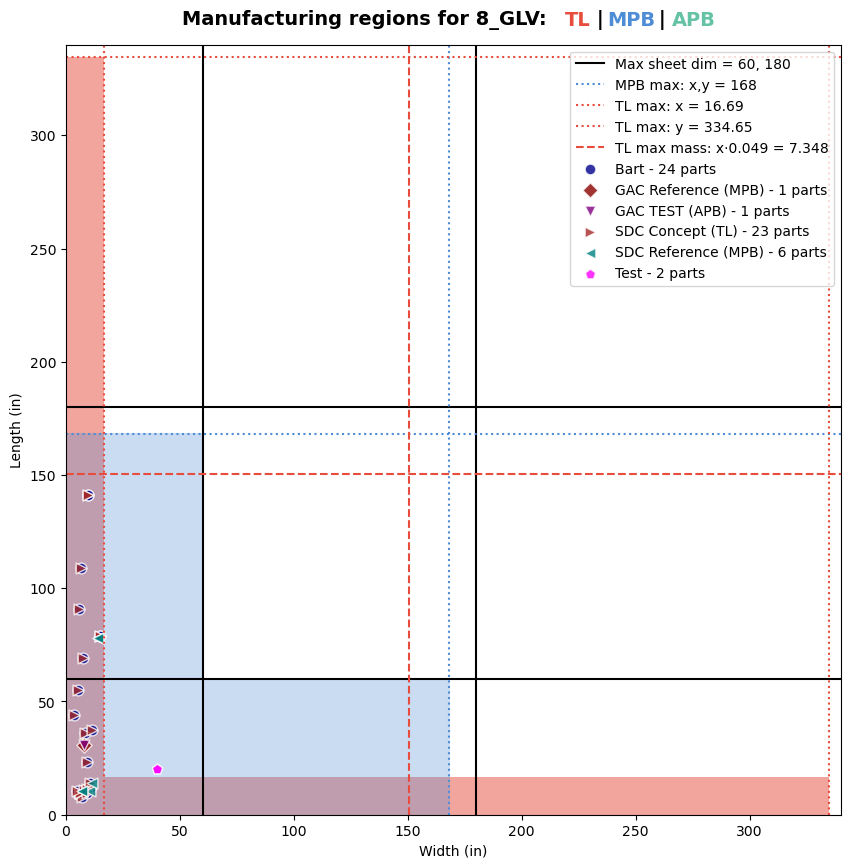

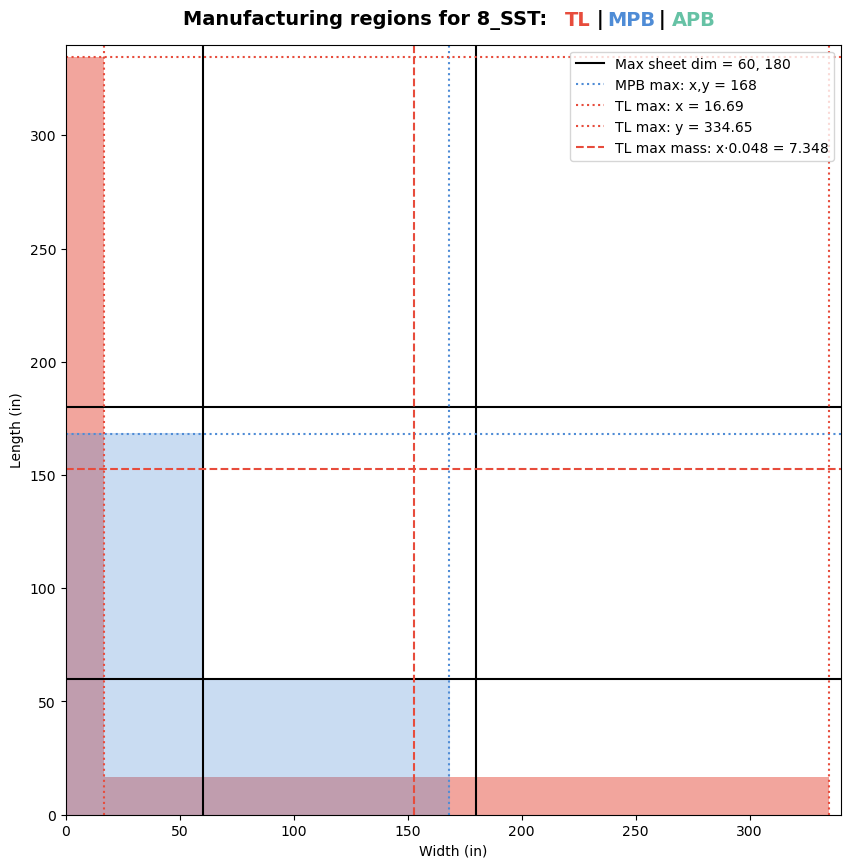

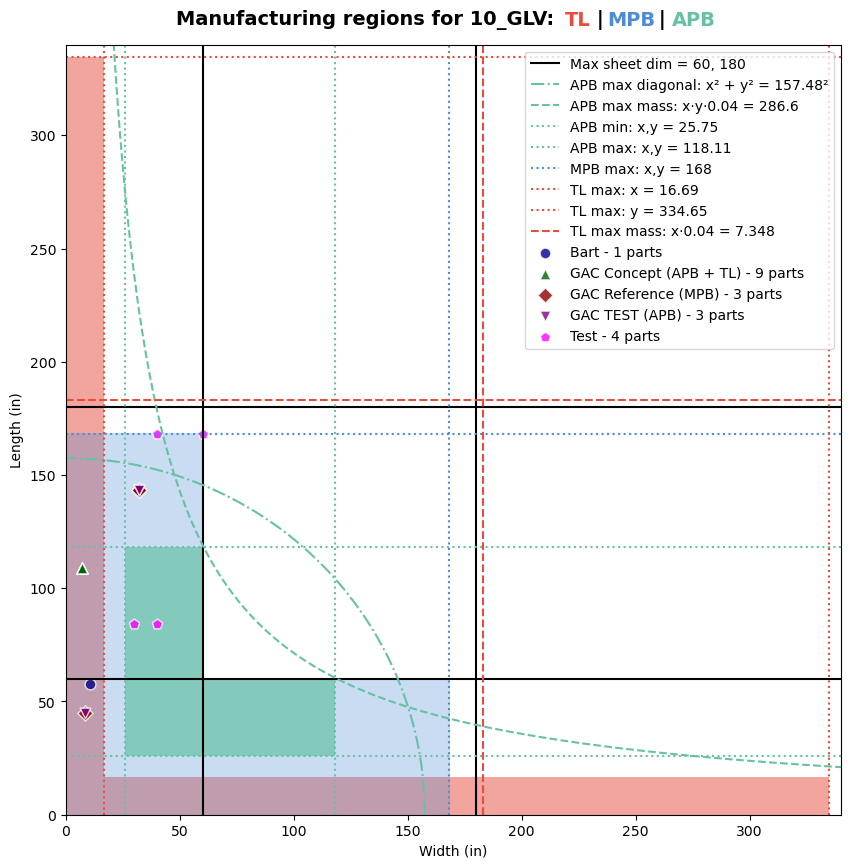

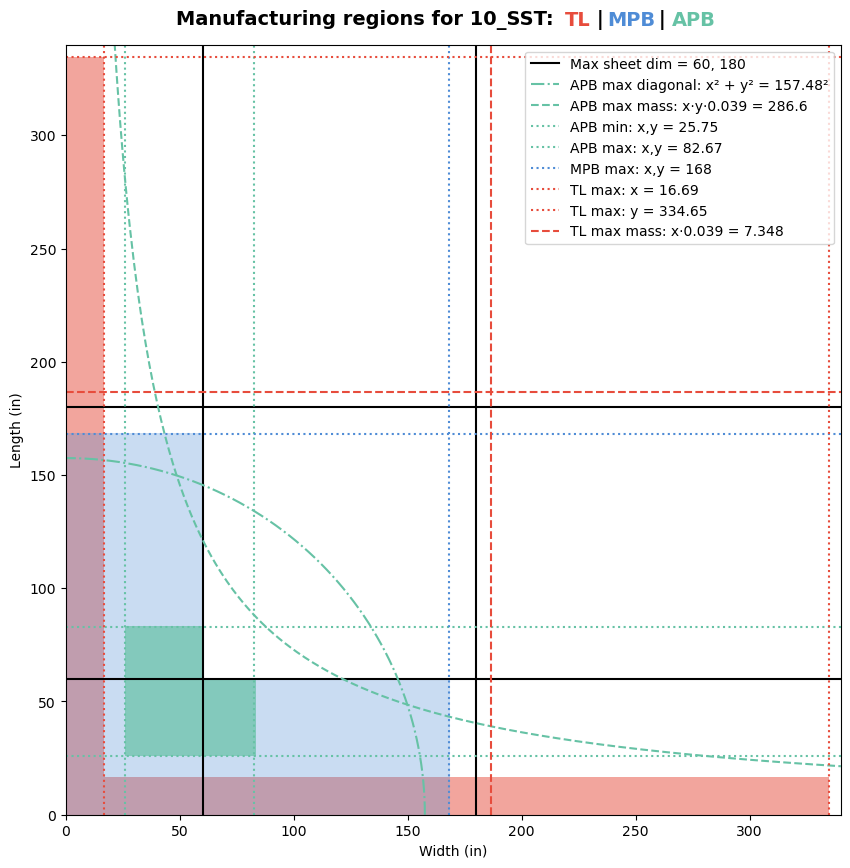

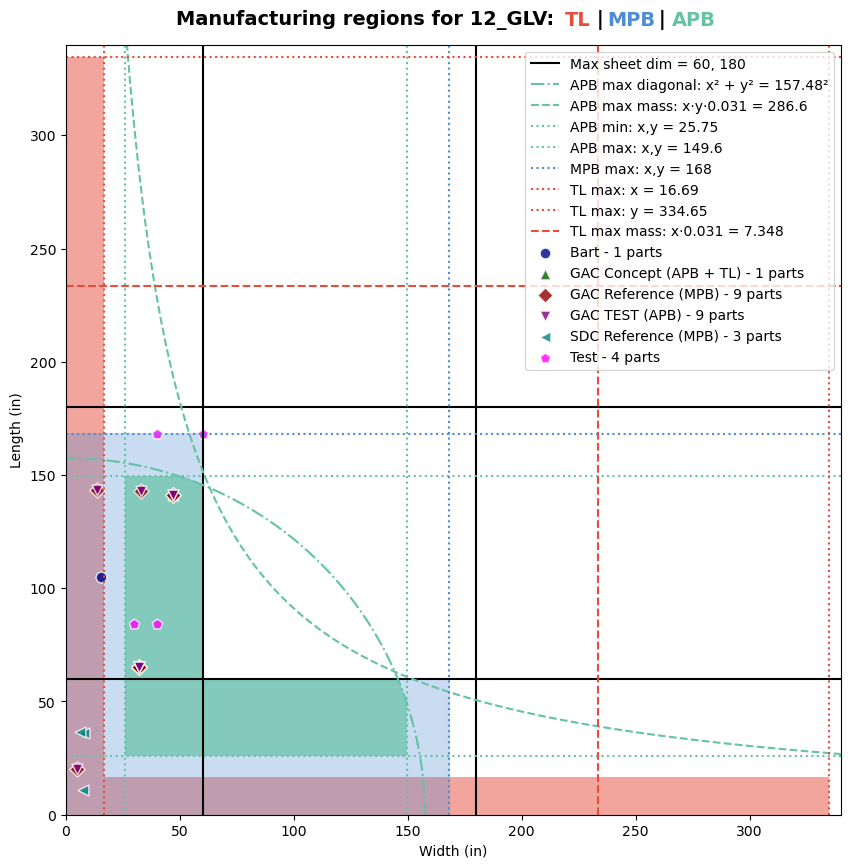

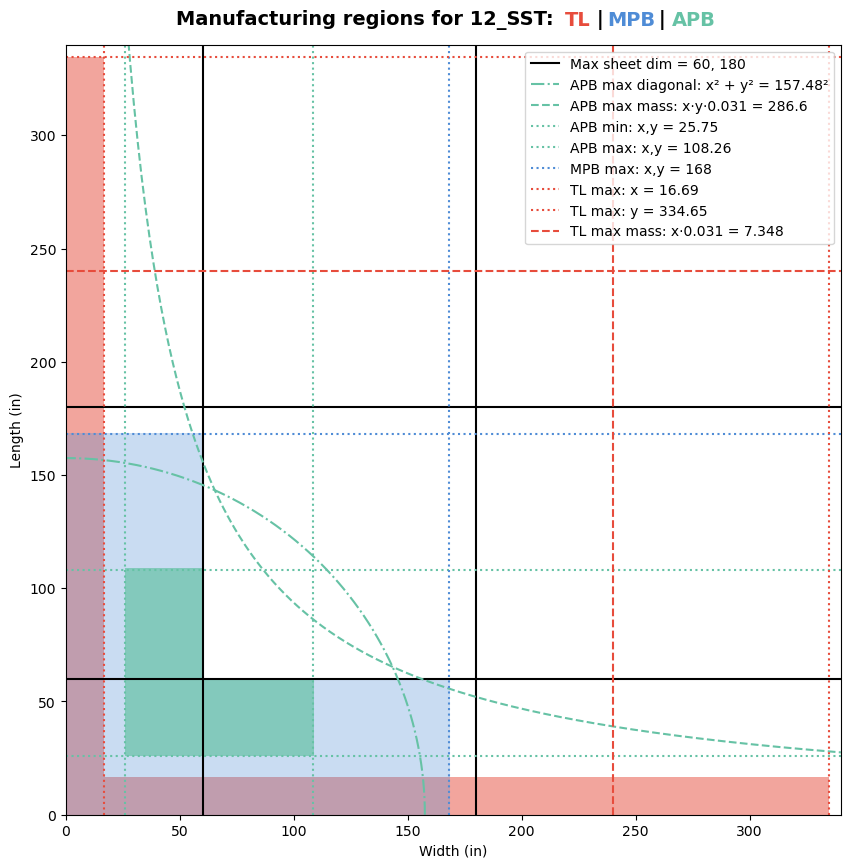

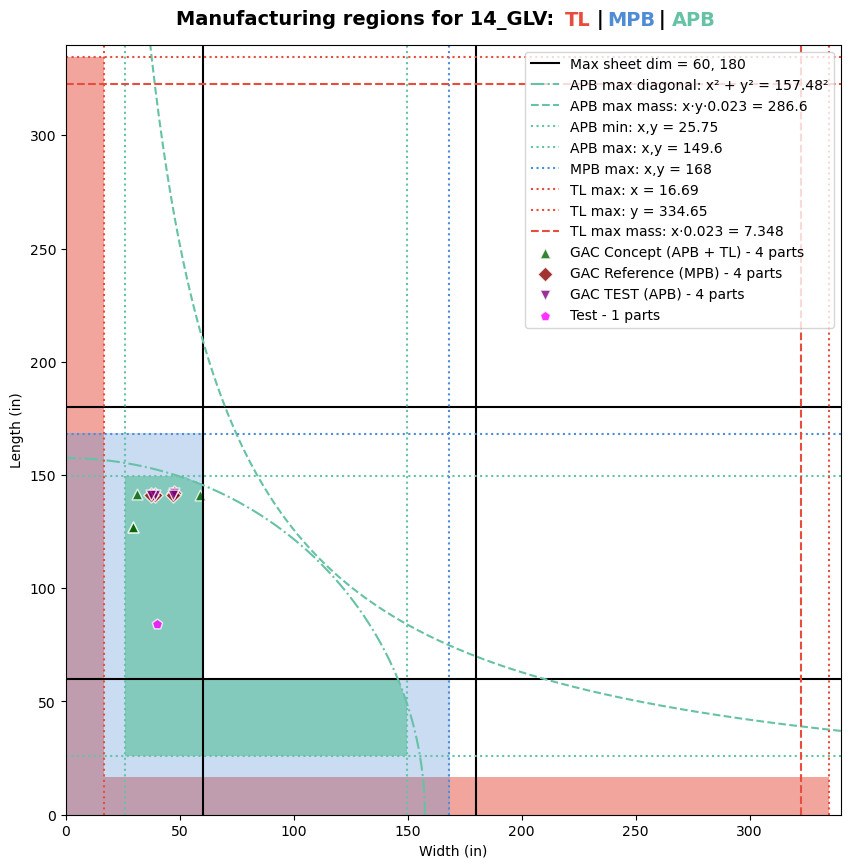

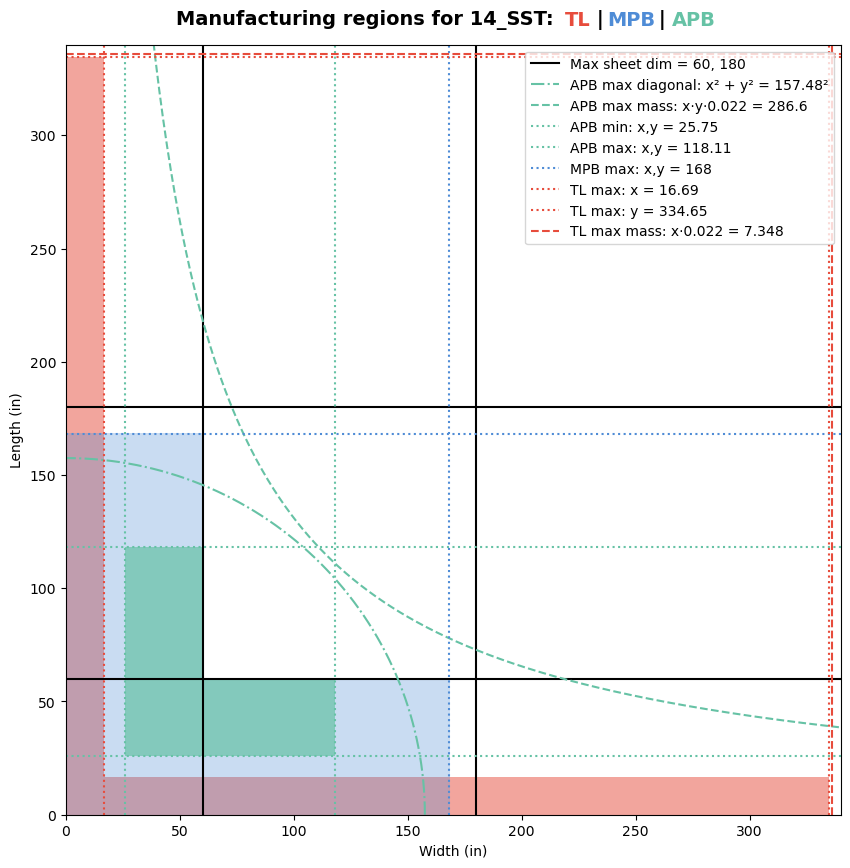

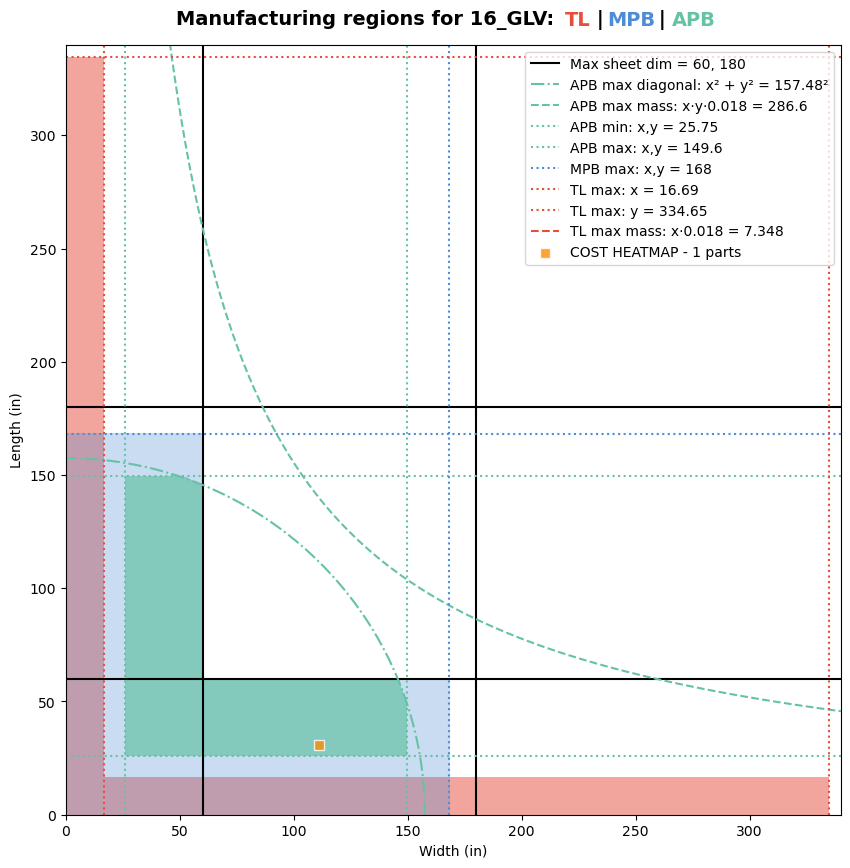

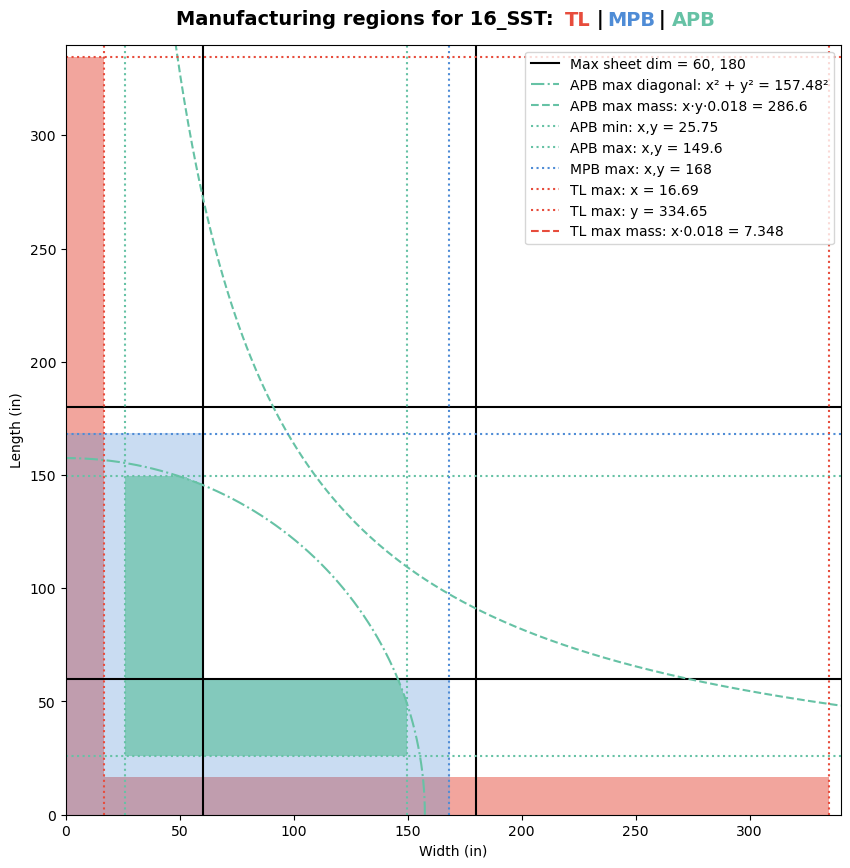

In [5]:
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.plot_feasible_regions()
        cap.add_part_sets(part_sets)

Starting cost run chart generation...
Parameters: diagonal direction from (5, 5) to (55, 55)
Spacing: 5, Fastener spacing: 3
Generated 11 path points
Calculating feasible combinations...
  Point 1: (5.0, 5.0) -> ['MPB', 'TL']
  Point 2: (10.0, 10.0) -> ['MPB', 'TL']
  Point 3: (15.0, 15.0) -> ['MPB', 'TL']
  Point 4: (20.0, 20.0) -> ['MPB']
  Point 5: (25.0, 25.0) -> ['MPB']
  Point 6: (30.0, 30.0) -> ['MPB', 'APB']
  Point 7: (35.0, 35.0) -> ['MPB', 'APB']
  Point 8: (40.0, 40.0) -> ['MPB', 'APB']
  Point 9: (45.0, 45.0) -> ['MPB', 'APB']
  Point 10: (50.0, 50.0) -> ['MPB', 'APB']
  Point 11: (55.0, 55.0) -> ['MPB', 'APB']
Total feasible combinations: 20
Preparing batch inputs...
Prepared 20 calculations for batch processing
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 169...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 20 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Processing re

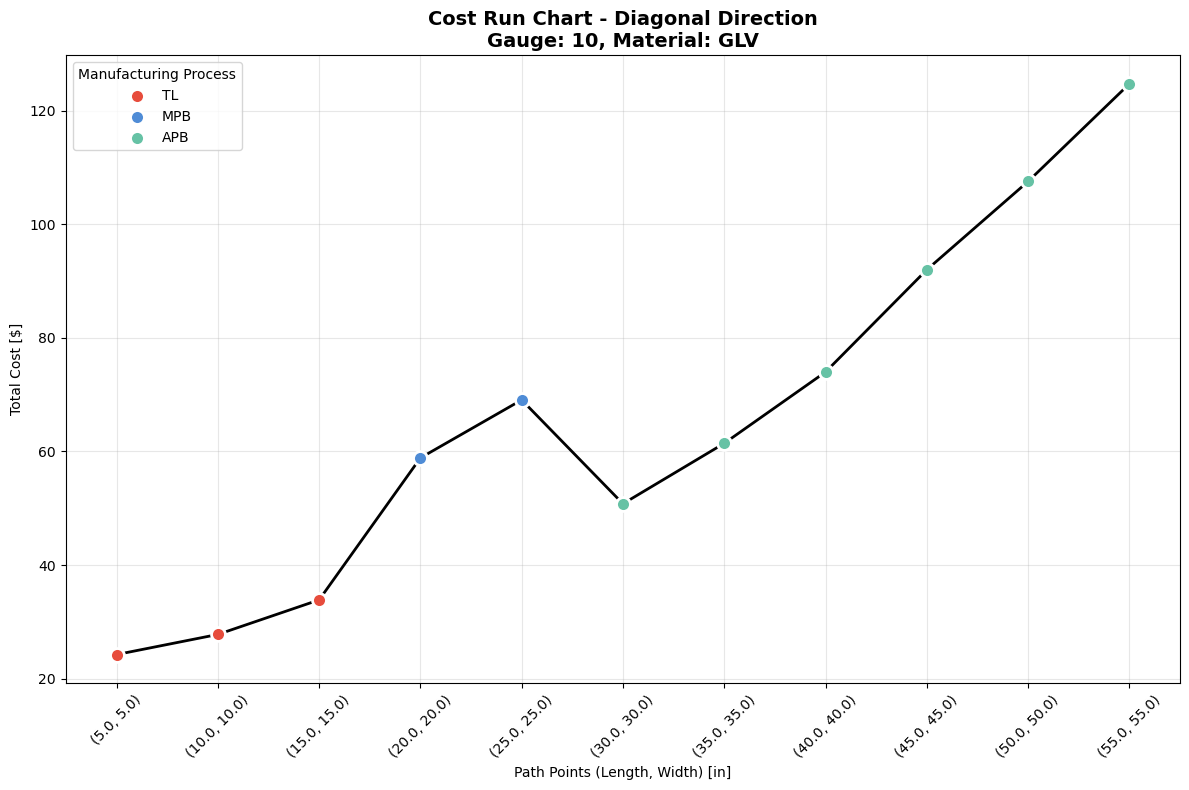


Cost Run Chart Summary:
Direction: diagonal
Range: (5.0, 5.0) to (55.0, 55.0)
Number of points: 11
Cost range: $24.23 - $124.71
Function completed successfully!
Generating costs for region: MPB
Number of feasible points: 715
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 864...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 715 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: APB
Number of feasible points: 203
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 352...
Calculating Excel formulas...
Excel calculation completed
Reading batch results...
Read 203 cost values
Clearing Excel inputs...
Excel inputs cleared
Excel closed
Generating costs for region: TL
Number of feasible points: 520
Opening Excel workbook...
Excel opened successfully
Writing inputs to rows 150 to 669...
Calculating Excel formulas...
Excel calculation comple

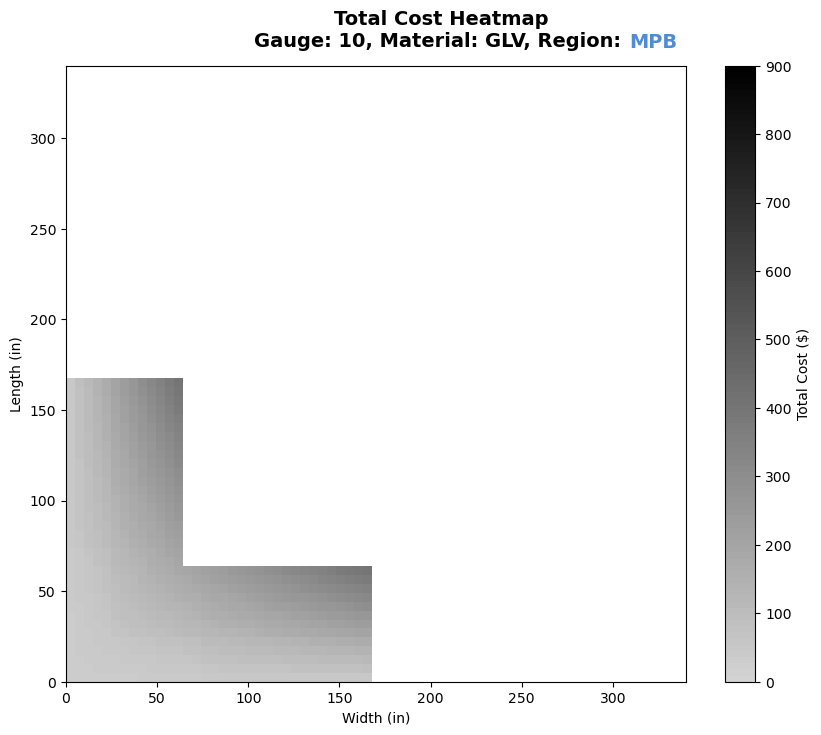

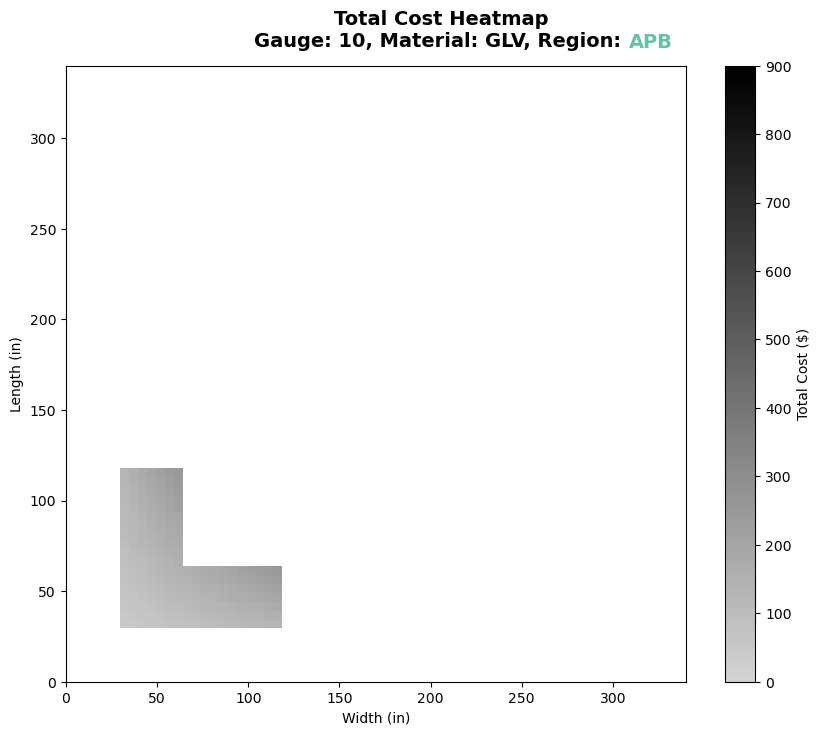

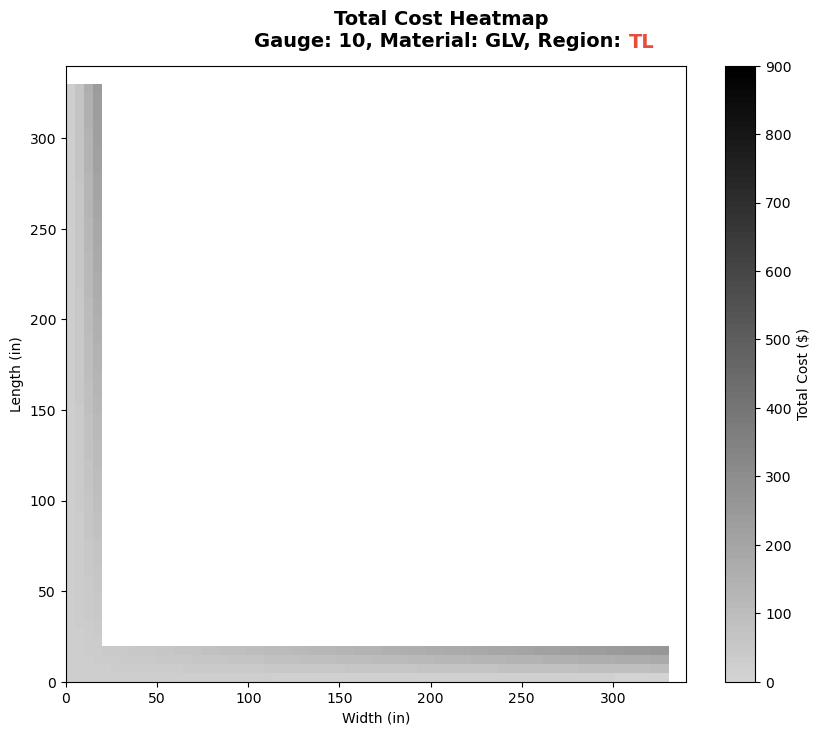

In [6]:
cap = Capabilities('GLV', 10)

# # Increase length from 50 to 100, keeping width at 30
# results = cap.cost_run_chart(path, 100, 50, 150, 50, 'length', 5)

# # Increase width from 20 to 60, keeping length at 80  
# results = cap.cost_run_chart(path, 15, 130, 15, 180, 'width', 5)

# Diagonal increase from (40,30) to (100,80)
results = cap.plot_cost_run_chart(path, 5, 5, 55, 55, 'diagonal', 5)

# cap.process_cost_difference(path, fastener_spacing, bolt_diameter)

cap.plot_individual_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)